<a href="https://colab.research.google.com/github/codewithhari98/Machine_Learning/blob/main/Neural_network_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Idea1: create a global w and b of size L which is number of layers
#https://www.youtube.com/watch?v=RSl87lqOXDE&ab_channel=CoreySchafer
#https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce654
#https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
#http://neuralnetworksanddeeplearning.com/chap1.html
#https://www.educative.io/answers/one-hot-encoding-in-python
#https://e2eml.school/softmax.html
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
class Layer:
  def __init__(self,inputsize,outputsize):
    self.input=inputsize
    self.output=outputsize
    self.weights = np.random.rand(inputsize, outputsize) - 0.5
    self.bias = np.random.rand(1, outputsize) - 0.5
    self.z=0
  def forward_propagation(self, input):
    raise NotImplementedError
  def backward_propagation(self, output_error, learning_rate):
     raise NotImplementedError
    

In [3]:
class linearlayer(Layer):
  def forward_propagation(self,input):
    self.input_data=input
    f=np.dot(self.input_data, self.weights) + self.bias
    #print("input:  ",self.input_data)
    #print("weights:  ",self.weights)
    #print("bias:  ",self.bias)
    return f
  def backward_propagation(self,output_error,learning_rate):
    #diff of function f wrt weights gives input data 
    dfw=self.input_data
    dfx=self.weights
    #calculating sensitivity of cost wrt previous activation layer
    input_error = np.dot(output_error, dfx.T)
    #calculating sensitivity of cost wrt change in weights
    weights_error = np.dot(dfw.T, output_error)

    self.weights=self.weights-learning_rate*weights_error
    self.bias=self.bias-learning_rate*output_error

    #print("weights====", self.weights)
    #this returns the sensitivity of the cost func wrt previous activation func
    #which will be useful to calc the change in weights needed at inp
    return input_error

In [4]:
class sigmoid(Layer):
  def __init__(self):
    pass
  def forward_propagation(self,input):
    self.input_data=input
    #self.z=(np.dot(self.input_data, self.weights) + self.bias)
    #return 1. / (1. + np.exp(-self.z))
    return 1. / (1. + np.exp(-self.input_data))
  def backward_propagation(self, output_error, learning_rate):
    #sig_prime= (1. / (1. + np.exp(-self.z)))*(1- (1. / (1. + np.exp(-self.z))))*output_error*self.weights.T 
    sig_prime= (1. / (1. + np.exp(-self.input_data)))*(1- (1. / (1. + np.exp(-self.input_data))))*output_error
    return sig_prime



In [5]:
class tanh(Layer):
  def __init__(self):
    pass
  def forward_propagation(self,input):
    self.input_data=input
    #self.z=(np.dot(self.input_data, self.weights) + self.bias)
    #tanh_val=(np.exp(self.z) - np.exp(-self.z)) / (np.exp(self.z) + np.exp(-self.z))
    tanh_val=(np.exp(self.input_data) - np.exp(-self.input_data)) / (np.exp(self.input_data) + np.exp(-self.input_data))
    return tanh_val
  def backward_propagation(self, output_error,learning_rate):
    #tanh_val=(np.exp(self.z) - np.exp(-self.z)) / (np.exp(self.z) + np.exp(-self.z))
    tanh_val=(np.exp(self.input_data) - np.exp(-self.input_data)) / (np.exp(self.input_data) + np.exp(-self.input_data))
    tanh_prime= (1-(tanh_val)**2)*output_error 
    #print("tanh_prime:    ",tanh_prime)
    return tanh_prime

In [6]:
class softmax(Layer):
  def forward_propagation(self,input):
    self.input_data=input
    self.z=(np.dot(self.input_data, self.weights) + self.bias)
    num = np.exp(self.z- np.max(self.z))
    return num / np.sum(num, axis=0, keepdims=True)
    
  #*****************************************************#
  def backward_propagation(self, probs, bp_err):
    dim = probs.shape[1]
    output = np.empty(probs.shape)
    for j in range(dim):
        d_prob_over_xj = - (probs * probs[:,[j]])  # i.e. prob_k * prob_j, no matter k==j or not
        d_prob_over_xj[:,j] += probs[:,j]   # i.e. when k==j, +prob_j
        output[:,j] = np.sum(bp_err * d_prob_over_xj, axis=1)
    return output

In [7]:
class crossentropy(Layer):
  def forward_propagation(pred, target):
    return -target * np.log(pred)
  def backward_propagation(pred, target):
    return target - pred

In [8]:
#to calculate the loss function and its derivative
#class output_error:
def mse(y_true, y_pred):
  return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
  return 2*(y_pred-y_true)/y_true.size;

In [9]:
class sequential_class(Layer):
  def __init__(self,loss=None,loss_grad=None):
    self.layers = []
    self.loss=loss
    self.loss_grad=loss_grad
  def add_layer(self,newlayer):
    self.layers.append(newlayer)
    return(self.layers)
  def display_weights(self):
    for layer in self.layers:
      print(layer.weights)
  def predict(self,input):
    samplesize=len(input)
    predictions=[]
    for i in range(samplesize):
      output=input[i]
      #print("output1= ",samplesize)
      for layer in self.layers:
        output = layer.forward_propagation(output)
        #print("output= "+str(layer),output)
      predictions.append(output)
    return predictions
  def fit(self, x_train, y_train, epochs, learning_rate):
    samplesize=len(x_train)
    for i in range(epochs):
      errorval=0
      for j in range(samplesize):
      # forward propagation
        output = x_train[j]
        #print(output)
        for layer in self.layers:
          #print(layer)
          output = layer.forward_propagation(output)
          # compute loss (for display purpose only)
        errorval += self.loss(y_train[j], output)
          # backward propagation
        error = self.loss_grad(y_train[j], output)
        for layer in reversed(self.layers):
          error = layer.backward_propagation(error, learning_rate)

      # calculate average error on all samples
      errorval /= samplesize
      print('epoch %d/%d   error=%f' % (i+1, epochs, errorval))


In [10]:
#model1=linearlayer(5,4)
#print(model1.output)
#model=Layer()
#print("weights: ", model1.weights)
#print("bias: ",model1.bias)

In [11]:
#model1=sequential_class()
#val1=model1.add_layer(linearlayer(5,4))
#val2=model1.add_layer(linearlayer(2,2))
#val3=model1.add_layer(linearlayer(2,2))
#model1.display_weights()
#print(val3)
#print("weights: ", model1.weights)
#print("bias: ",model1.bias)

In [12]:
def XOR_Test():
  x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
  y_train = np.array([[[0]], [[1]], [[1]], [[0]]])
  model2=sequential_class(mse,mse_prime)
  model2.add_layer(linearlayer(2,3))
  model2.add_layer(tanh())
  model2.add_layer(linearlayer(3,1))
  val4=model2.add_layer(tanh())
  #print(val4)
  model2.fit(x_train, y_train, epochs=5000, learning_rate=0.01)
  out = model2.predict(x_train)
  print(out)

In [13]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

In [14]:
def mnist_train_test():

  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  # reshape and normalize input data
  x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
  x_train = x_train.astype('float32')
  x_train /= 255
  y_train = np_utils.to_categorical(y_train)

  # same for test data : 10000 samples
  x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
  x_test = x_test.astype('float32')
  x_test /= 255
  y_test = np_utils.to_categorical(y_test)
  mnist_network_layers = sequential_class(mse,mse_prime)
  mnist_network_layers.add_layer(linearlayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
  mnist_network_layers.add_layer(tanh())
  mnist_network_layers.add_layer(linearlayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
  mnist_network_layers.add_layer(tanh())
  mnist_network_layers.add_layer(linearlayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
  mnist_network_layers.add_layer(tanh())
  mnist_network_layers.fit(x_train, y_train, epochs=70, learning_rate=0.1)
  samples = 10
  for test, true in zip(x_test[:samples], y_test[:samples]):
      image = np.reshape(test, (28, 28))
      plt.imshow(image, cmap='binary')
      plt.show()
      pred = mnist_network_layers.predict(test)
      idx = np.argmax(pred)
      idx_true = np.argmax(true)
      print('pred: %s, true: %d' % (idx, idx_true))

In [15]:
def main():
  print("...................................Doint Xor Testing...........................................\n\n")
  XOR_Test()
  print("..................................Training and testing on mnist Dataset.........................\n\n" )
  mnist_train_test()

Streaming output truncated to the last 5000 lines.
epoch 78/5000   error=0.257266
epoch 79/5000   error=0.257242
epoch 80/5000   error=0.257218
epoch 81/5000   error=0.257194
epoch 82/5000   error=0.257170
epoch 83/5000   error=0.257147
epoch 84/5000   error=0.257124
epoch 85/5000   error=0.257101
epoch 86/5000   error=0.257079
epoch 87/5000   error=0.257057
epoch 88/5000   error=0.257035
epoch 89/5000   error=0.257013
epoch 90/5000   error=0.256991
epoch 91/5000   error=0.256970
epoch 92/5000   error=0.256949
epoch 93/5000   error=0.256928
epoch 94/5000   error=0.256908
epoch 95/5000   error=0.256888
epoch 96/5000   error=0.256868
epoch 97/5000   error=0.256848
epoch 98/5000   error=0.256828
epoch 99/5000   error=0.256808
epoch 100/5000   error=0.256789
epoch 101/5000   error=0.256770
epoch 102/5000   error=0.256751
epoch 103/5000   error=0.256732
epoch 104/5000   error=0.256714
epoch 105/5000   error=0.256696
epoch 106/5000   error=0.256677
epoch 107/5000   error=0.256659
epoch 108/5

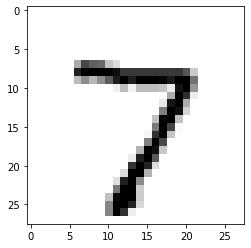

pred: 7, true: 7


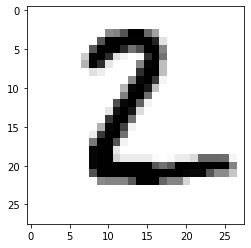

pred: 2, true: 2


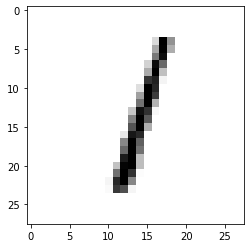

pred: 1, true: 1


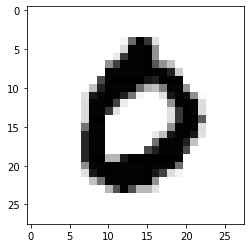

pred: 0, true: 0


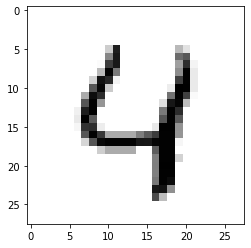

pred: 4, true: 4


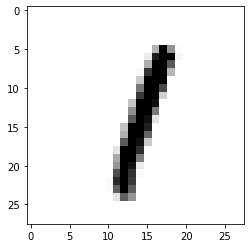

pred: 1, true: 1


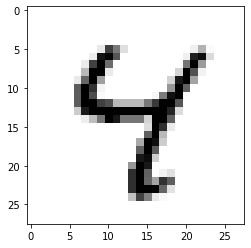

pred: 4, true: 4


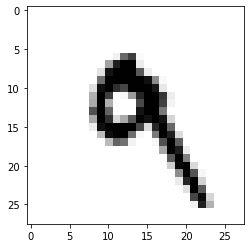

pred: 9, true: 9


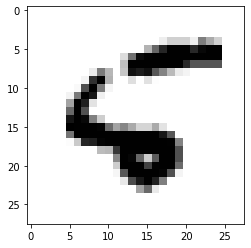

pred: 5, true: 5


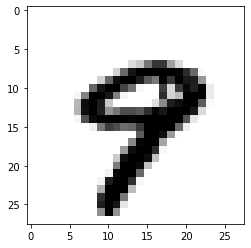

pred: 9, true: 9


In [16]:
if __name__ == "__main__" :   
    main()